In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import multiprocessing as multi
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, interpn
from scipy.optimize import linprog
import seaborn as sns
import sys
from tqdm import tqdm_notebook, tqdm

d = 'vt'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

sns.set_style('ticks')
sns.set_palette('colorblind')
sns.set_context('notebook')

In [3]:
MMin = 5
MMax = 50

def draw_m1m2(size=1):
    u1s = np.random.uniform(size=size)
    u2s = np.random.uniform(size=size)
    
    m1s = exp(u1s*log(MMax) + (1-u1s)*log(MMin))
    m2s = m1s*u2s + MMin*(1-u2s)
    
    return (m1s, m2s)

In [4]:
R0 = 60.0 # Gpc^-3 yr^-1
T = 5.0 # yr
duty_cycle = 0.5
gamma = 2.7

zMax = 1.75

zs = expm1(linspace(log(1), log(1+zMax), 1024))
dNdz = T*R0*duty_cycle*(1+zs)**(gamma-1)*4*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value
Nz = cumtrapz(dNdz, zs, initial=0)

icdf_z = interp1d(Nz/Nz[-1], zs)

def draw_z(factor=1):
    N = np.random.poisson(Nz[-1]*factor)
    
    return icdf_z(np.random.uniform(size=N))

In [5]:
def draw_ra_dec(size=1):
    ra = np.random.uniform(low=0, high=2*pi, size=size)
    sin_dec = np.random.uniform(low=-1, high=1, size=size)
    
    return ra, arcsin(sin_dec)

In [6]:
fmin = 9.0
fref = 40.0
psdstart = 10.0

snr_thresh = 8*sqrt(2) # 8 in at least two detectors

def next_pow_two(x):
    x2 = 1
    while x2 < x:
        x2 = x2 << 1
    
    return x2

def generate_waveform(m1, m2, z):
    dL = cosmo.Planck15.luminosity_distance(z).to(u.Gpc).value
        
    tmax = vt.ls.SimInspiralChirpTimeBound(fmin, m1*(1+z)*vt.lal.MSUN_SI, m2*(1+z)*vt.lal.MSUN_SI, 0.0, 0.0) + 2
    
    df = 1.0/next_pow_two(tmax)
    fmax = 2048.0 # Hz --- based on max freq of 5-5 inspiral
    
    cos_i = np.random.uniform(low=-1, high=1)
    phi_ref = np.random.uniform(low=0, high=2*pi)
    
    hp, hc = vt.ls.SimInspiralChooseFDWaveform((1+z)*m1*vt.lal.MSUN_SI, (1+z)*m2*vt.lal.MSUN_SI, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, dL*1e9*vt.lal.PC_SI, arccos(cos_i), phi_ref, 0.0, 0.0, 0.0, df, fmin, fmax, fref, None, vt.ls.IMRPhenomPv2)
    
    return hp, hc

def compute_detector_snrs(hp, hc, ra, dec):
    psi = np.random.uniform(low=0, high=2*pi)
    gmst = np.random.uniform(low=0, high=2*pi)
    
    snrs = []
    for det in ['H1', 'L1', 'V1']:
        Fp, Fc = vt.lal.ComputeDetAMResponse(vt.lal.cached_detector_by_prefix[det].response, ra, dec, psi, gmst)
        
        h = vt.lal.CreateCOMPLEX16FrequencySeries("h", vt.lal.LIGOTimeGPS(0), 0.0, hp.deltaF, hp.sampleUnits, hp.data.length)
        h.data.data = Fp*hp.data.data + Fc*hc.data.data
        
        fmax = hp.deltaF*(hp.data.length - 1)
        df = hp.deltaF
        Nf = hp.data.length

        fs = linspace(0, fmax, Nf)
        sel = fs > psdstart

        sffs = vt.lal.CreateREAL8FrequencySeries("psds", 0, 0.0, df, vt.lal.DimensionlessUnit, fs.shape[0])
        if det == 'H1' or det == 'L1':
            vt.ls.SimNoisePSDaLIGOaLIGODesignSensitivityT1800044(sffs, psdstart)
        elif det == 'V1':
            vt.ls.SimNoisePSDAdVDesignSensitivityP1200087(sffs, psdstart)
        else:
            raise ValueError('detector must be one of H1, L1, V1')
        
        rho = vt.ls.MeasureSNRFD(h, sffs, psdstart, -1.0)
        n = randn()
        
        snrs.append(sqrt((rho+n)*(rho+n)))
        
    return array(snrs)

def approx_mdet_threshold(z):
    # Come from a constrained optimization problem.
    m, b = array([19.87217405, -0.47620653])
    return m*z + b

def draw_snr(m1, m2, z, ra, dec):
    if m1 < approx_mdet_threshold(z):
        return (m1, m2, z, ra, dec, 0.0)
    else:
        hp, hc = generate_waveform(m1, m2, z)
        snrs = compute_detector_snrs(hp, hc, ra, dec)
        snr = np.sqrt(np.sum(snrs*snrs))

        return (m1,m2,z,ra,dec,snr)

def draw_snr_onearg(x):
    return draw_snr(*x)

def downselect(m1s, m2s, zs, ras, decs, processes=None):
    m1s_sel = []
    m2s_sel = []
    zs_sel = []
    ras_sel = []
    decs_sel = []
    snrs_sel = []
    
    #s = m1s > approx_mdet_threshold(zs)
    p = multi.Pool(processes=processes)
    try:
        for m1, m2, z, ra, dec, snr in tqdm(p.imap(draw_snr_onearg, zip(m1s, m2s, zs, ras, decs), chunksize=1024), total=len(zs)):
            if snr > snr_thresh:
                m1s_sel.append(m1)
                m2s_sel.append(m2)
                zs_sel.append(z)
                ras_sel.append(ra)
                decs_sel.append(dec)
                snrs_sel.append(snr)
    finally:
        p.close()
            
    return array(m1s_sel), array(m2s_sel), array(zs_sel), array(ras_sel), array(decs_sel), array(snrs_sel)

In [9]:
zs = draw_z(factor=10)
NN = len(zs)

m1s, m2s = draw_m1m2(size=NN)
ras, decs = draw_ra_dec(size=NN)

m1, m2, z, ra, dec, snr = downselect(m1s, m2s, zs, ras, decs, processes=4)
    
with h5py.File('better-random-comoving-positions.h5', 'w') as f:  
    def cd(n, d):
        f.create_dataset(n, data=d, compression='gzip', shuffle=True)
    cd('m1s', m1)
    cd('m2s', m2)
    cd('zs', z)
    cd('dcs', Planck15.comoving_distance(z).to(u.Gpc).value)
    cd('dls', Planck15.luminosity_distance(z).to(u.Gpc).value)
    cd('ras', ra)
    cd('decs', dec)
    cd('snrs', snr)

100%|██████████| 2843942/2843942 [2:35:52<00:00, 304.10it/s]  


In [7]:
with h5py.File('better-random-comoving-positions.h5', 'r') as f:
    def gd(n):
        return array(f[n])
    
    m1 = gd('m1s')
    m2 = gd('m2s')
    z = gd('zs')
    ra = gd('ras')
    dec = gd('decs')
    snr = gd('snrs')

In [8]:
scatter(z, m1)
zline = linspace(0, 1.75)
plot(zline, approx_mdet_threshold(zline))

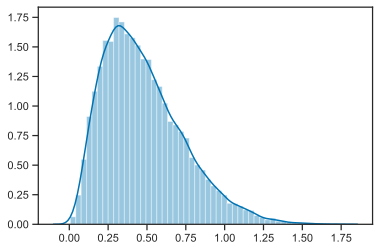

In [9]:
sns.distplot(z)

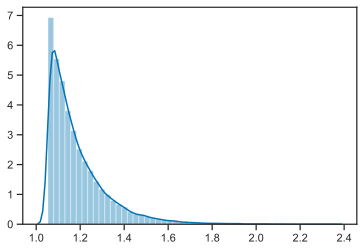

In [10]:
sns.distplot(log10(snr))

In [11]:
N = len(m1)

In [12]:
N

24012

In [13]:
dc = Planck15.comoving_distance(z).to(u.Mpc).value

In [14]:
pts = dc[:5000,newaxis]*column_stack((cos(ra[:5000])*cos(dec[:5000]), sin(ra[:5000])*cos(dec[:5000]), sin(dec[:5000])))

In [15]:
rs = pts[newaxis,:,:]-pts[:,newaxis,:]

In [16]:
r2s = np.sum(rs*rs, axis=2)

In [18]:
sqrt(np.min(r2s[r2s>0]))

10.050209191921775

In [19]:
Planck15.comoving_volume(0.5)

<Quantity 3.08477409e+10 Mpc3>

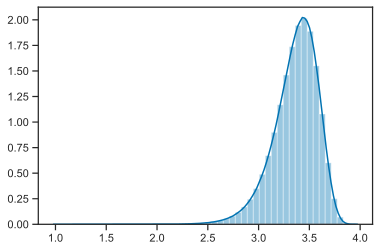

In [20]:
sns.distplot(log10(sqrt(r2s[r2s>0])))